In [1]:
import pandas as pd
import re
import nltk
from nltk.tokenize import sent_tokenize
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from operator import add
from scripts.detail_extractor import actionTaken, getViolations, getViolators, getAllPenalties, getDate, getViolations2, getViolations3

In [2]:
import en_core_web_lg
nlp = en_core_web_lg.load()

In [3]:
def identify_crime(text, types, folders):
    text = text.lower()
    data = []
    count = [0, 0, 0, 0]
    for i in range(len(types)):
        if(text.find(types[i]) != -1):
            data.append(folders[i])
            count[i] = 1
    return data, count

In [4]:
def create_graph(final_nodes):
    source = []
    target = []
    edge = []
    indexes = []

    for i in (range(len(final_nodes))):
        ent1 = final_nodes[i][0]
        ent2 = final_nodes[i][2]
        rel = final_nodes[i][1] 
        source.append(ent1.lower().strip())
        target.append(ent2.lower().strip())
        edge.append("".join(rel).strip())
        indexes.append(i)
    if(len(edge) == 0 or len(final_nodes) == 0):
        return None
    else:
        G = nx.DiGraph(directed=True)
        for i in (range(len(edge))):
            G.add_weighted_edges_from([(source[i], target[i], i)])
        size=20
        if len(edge)/2 > 20:
            size = len(edge)/2
        plt.figure(figsize = (size, size))
        edge_labels = dict([((u, v, ), edge[d['weight']]) for u, v, d in G.edges(data = True)])
        pos = nx.spring_layout(G, k = 0.8)
        nx.draw(G, with_labels = True, node_color = 'lightblue', node_size=5000, edge_color='r', edge_cmap = plt.cm.Blues, pos=pos, font_size=20)
        nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size = 15)
        return G, edge_labels

In [5]:
df = pd.read_csv('./results/data_small.csv')

df.Text = df.Text.apply(lambda x : x.replace('\\n', '\n'))
df.Text = df.Text.apply(lambda x : x.replace('\\t', '\t'))

types = ['insider', 'misappropriate', 'unregister', 'fraud']
folders = ['Insider Trading', 'Misappropriated Funds', 'Unregistered', 'Fraud']
count = [0, 0, 0, 0]
crimes = []
actions = []
violations = []
violators = []
fines = []
dates = []
years = []

yrs = set()
counts = {}

for i in range(len(df['Text'])-30):
    text = df['Text'][i]
    crimes.append(identify_crime(text, types, folders)[0])
    action = actionTaken(text)
    violation = getViolations(text)
    violator = getViolators(text)
    fine = getAllPenalties(text)
    date, year = getDate(text)
    
    violations.append(violation)
    violators.append(violator)
    actions.append(action)
    fines.append(fine)
    dates.append(date)
    years.append(year)
    
    if(year != ''):
        yrs.add(year)
        
y = sorted(yrs)
        
for i in range(len(y)):
    counts[y[i]] = count
    
total = [0, 0, 0, 0]
    
for i in range(len(df['Text'])-30):
    text = df['Text'][i]
    _, count = identify_crime(text, types, folders)
    _, year = getDate(text)
    if(year != ''):
        counts[year] = list(map(add, counts[year], count))

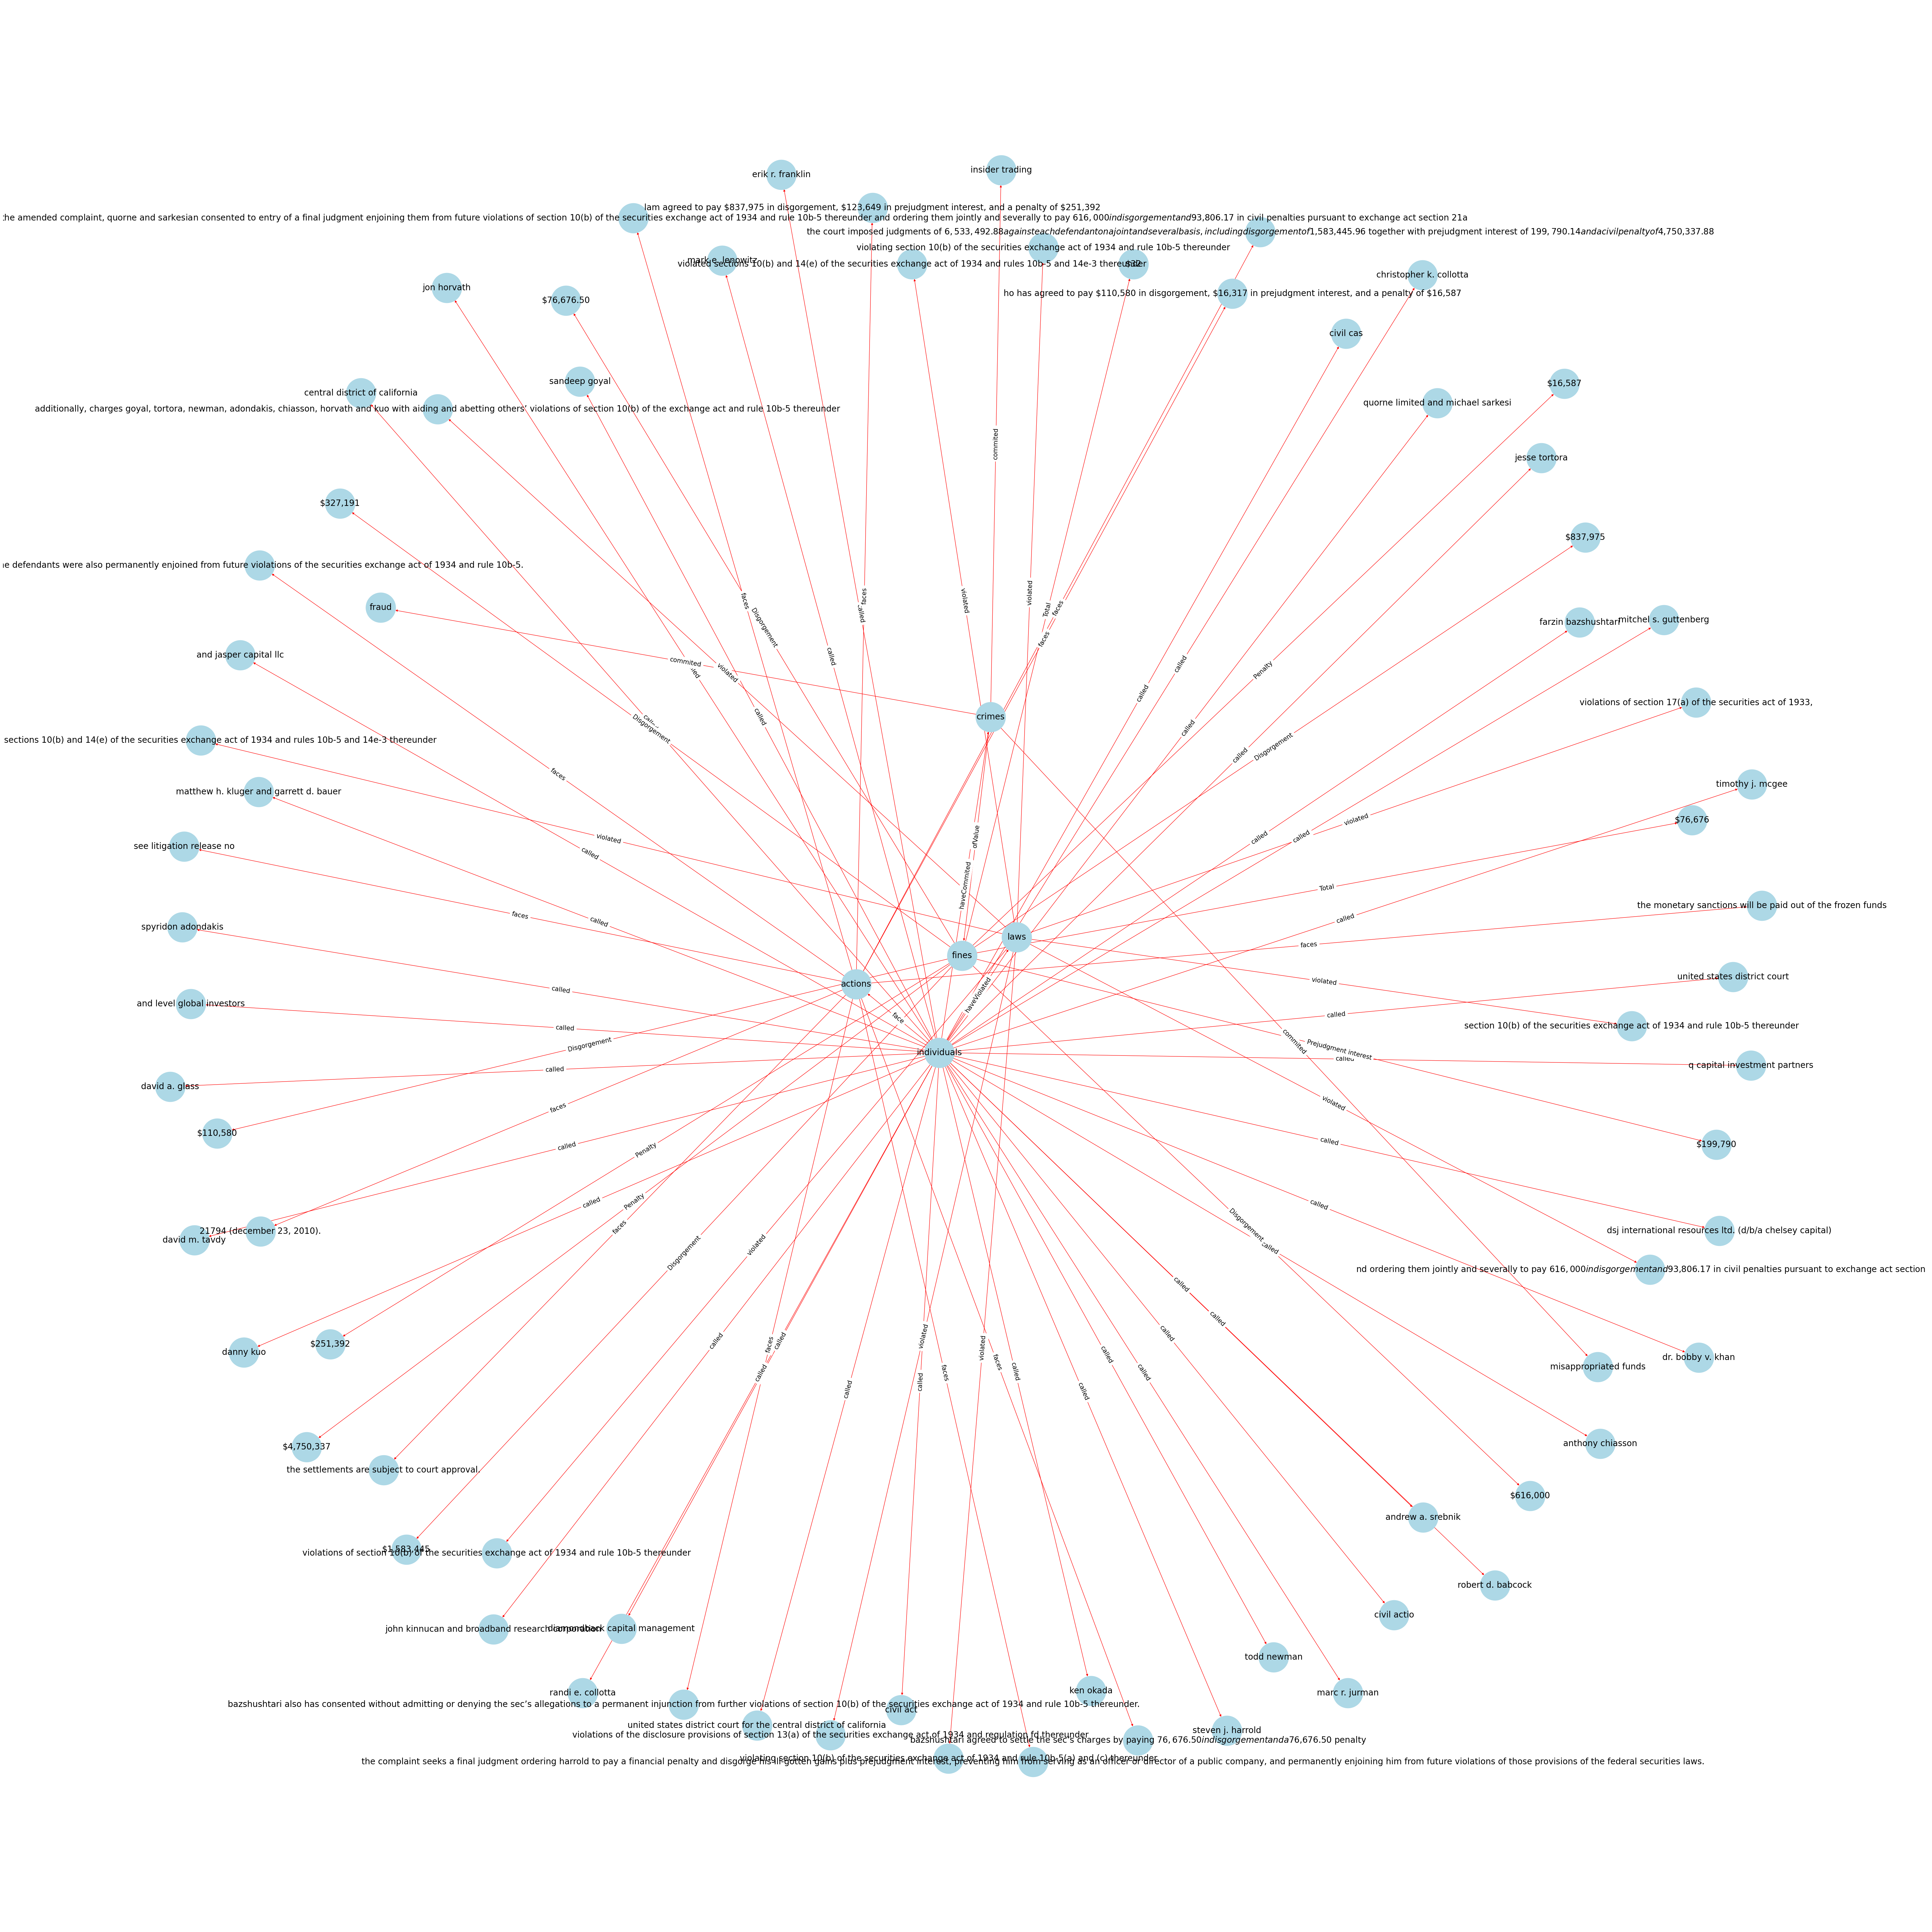

In [7]:
nodes = []

for i in range(len(crimes)):
    nodes.append(('individuals', 'haveCommited', 'crimes'))
    nodes.append(('individuals', 'haveViolated', 'laws'))
    nodes.append(('crimes', 'ofValue', 'fines'))
    nodes.append(('individuals', 'face', 'actions'))
    for violator in violators[i]:
        nodes.append(('individuals', 'called', violator))
    for crime in crimes[i]:
        nodes.append(('crimes', 'commited', crime))
    for violation in violations[i]:
        nodes.append(('laws', 'violated', violation))
    for action in actions[i]:
        nodes.append(('actions', 'faces', action))
    for fine in fines[i]:
        nodes.append(('fines', fine[0], fine[1]))

G = create_graph(nodes)

In [ ]:
print(nodes)

[('individuals', 'haveCommited', 'crimes'), ('individuals', 'haveViolated', 'laws'), ('crimes', 'ofValue', 'fines'), ('individuals', 'face', 'actions'), ('laws', 'violated', 'violations of the disclosure provisions of Section 13(a) of the securities exchange act of 1934 and regulation fd thereunder'), ('individuals', 'haveCommited', 'crimes'), ('individuals', 'haveViolated', 'laws'), ('crimes', 'ofValue', 'fines'), ('individuals', 'face', 'actions'), ('individuals', 'called', 'mitchel s. guttenberg'), ('individuals', 'called', 'erik r. franklin'), ('individuals', 'called', 'david m. tavdy'), ('individuals', 'called', 'mark e. lenowitz'), ('individuals', 'called', 'robert d. babcock'), ('individuals', 'called', 'andrew a. srebnik'), ('individuals', 'called', 'ken okada'), ('individuals', 'called', 'david a. glass'), ('individuals', 'called', 'marc r. jurman'), ('individuals', 'called', 'randi e. collotta'), ('individuals', 'called', 'christopher k. collotta'), ('individuals', 'called', 

In [ ]:
from neo4j import GraphDatabase

def create_graph_in_neo4j(final_nodes, uri, user, password):
    # Connect to Neo4j
    driver = GraphDatabase.driver(uri, auth=(user, password))

    with driver.session() as session:
        # Loop through the nodes and create them in Neo4j
        for node in final_nodes:
            ent1 = node[0].lower().strip()
            rel = node[1].replace(" ", "").strip() # Replace spaces with underscores
            ent2 = node[2].lower().strip()

            # Cypher query to create nodes and relationship
            query = (
                "MERGE (a:Entity {name: $ent1}) "
                "MERGE (b:Entity {name: $ent2}) "
                f"MERGE (a)-[r:{rel}]->(b)"
            )
            session.run(query, ent1=ent1, ent2=ent2)

    # Close the Neo4j driver connection
    driver.close()

# Example usage
uri = "neo4j+s://3c06059d.databases.neo4j.io"
user = "neo4j"
password = "NBHh_qlZyvenC5Qbz6Cn00Z0sJk6rNRSl0oRupYaUq0"
final_nodes = nodes
create_graph_in_neo4j(final_nodes, uri, user, password)
